In [163]:
# Initialize Otter
import otter
grader = otter.Notebook("hw07.ipynb")

<a id="top"></a>

# Homework 7: IMDb

We will use SQL to dive deep into the Internet Movie Database (IMDb) and answer different questions involving movies, actors, and movie ratings.

## Due Date: Thursday, April 11th, 11:59 PM

You must submit this assignment to Gradescope by the on-time deadline, Thursday, April 11th, 11:59 PM. Please read the syllabus for the grace period policy. No late submissions beyond the grace period will be accepted. **We strongly encourage you to plan to submit your work to Gradescope several hours before the stated deadline.** This way, you will have ample time to reach out to staff for support if you encounter difficulties with submission. While course staff is happy to help guide you with submitting your assignment ahead of the deadline, we will not respond to last-minute requests for assistance (TAs need to sleep, after all!).

Please read the instructions carefully when submitting your work to Gradescope.


##  Collaboration Policy

Data science is a collaborative activity. While you may talk with others about the homework, we ask that you **write your solutions individually**. If you do discuss the assignments with others, please **include their names** below.

**Collaborators**: *list collaborators here*

## Grading 

Grading is broken down into autograded answers and free response. For autograded answers, the results of your code are compared to provided and/or hidden tests. For free response, readers will evaluate how well you answered the question and/or fulfilled the requirements of the question.

<!--
<details>
    <summary>[Click to Expand] <b>Scoring Breakdown</b></summary>-->
|Question| Manual | Points|
|---|---|---|
|1a | No | 2 |
|1b | No | 2 |
|2 | No | 3 |
|3 | No | 3 |
|4a | No | 4 |
|4b | Yes | 2 |
|5 | No | 4 |
|Total | 1 |20 |
</details>

## Before You Start

For each question in the assignment, please write down your answer in the answer cell(s) right below the question. 

We understand that it is helpful to have extra cells breaking down the process towards reaching your final answer. If you happen to create new cells below your answer to run code, **NEVER** add cells between a question cell and the answer cell below it. It will cause errors when we run the autograder, and it will sometimes cause a failure to generate the PDF file.

**Important note: The local autograder tests will not be comprehensive. You can pass the automated tests in your notebook but still fail tests in the autograder.** Please be sure to check your results carefully.


### Debugging Guide
If you run into any technical issues, we highly recommend checking out the [Data 100 Debugging Guide](https://ds100.org/debugging-guide/). In this guide, you can find general questions about Jupyter notebooks / Datahub, Gradescope, common SQL errors, and more.

After running the cell below, you may be prompted to upgrade `jupysql` using `pip`. You do not need to worry about that; you do not need to add any additional cells for this setup.

In [164]:
# Run this cell to set up your notebook; no further action is needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import sqlalchemy
from pathlib import Path
import sql

plt.style.use('fivethirtyeight') # Use plt.style.available to see more styles
sns.set()
sns.set_context("talk")
np.set_printoptions(threshold=5) # Avoid printing out big matrices
%matplotlib inline
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


<br/><br/>

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## The IMDB (mini) Dataset

We will explore a miniature version of the [IMDb Dataset](https://www.imdb.com/interfaces/). This is the same dataset that we used for this week's lab.

**Caution: Be careful with large SQL queries!!** You may need to reboot your Jupyter Hub instance if it stops responding. To avoid printing out 100k-sized tables, we've adjusted the display limit to ensure that the tables displayed are truncated to 20 rows (though they may contain more rows in reality).

In [165]:
%config SqlMagic.displaylimit = 20

Let's set up the SQL database.

## Setup

Please just run the cells below to set up your SQL database and the autograder.

In [166]:
import duckdb
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [167]:
# Run this cell to connect to database
conn = duckdb.connect()
conn.query("INSTALL sqlite")

In [168]:
%sql duckdb:///data/imdbmini.db

Let's take a look at the table schemas:

In [169]:
%%sql
-- just run this cell --
SELECT * FROM sqlite_master WHERE type='table';

Running query in 'duckdb:///data/imdbmini.db'

type,name,tbl_name,rootpage,sql
table,Title,Title,0,"CREATE TABLE Title(tconst BIGINT, titleType VARCHAR, primaryTitle VARCHAR, originalTitle VARCHAR, isAdult VARCHAR, startYear VARCHAR, endYear VARCHAR, runtimeMinutes VARCHAR, genres VARCHAR);"
table,Name,Name,0,"CREATE TABLE ""Name""(nconst BIGINT, primaryName VARCHAR, birthYear VARCHAR, deathYear VARCHAR, primaryProfession VARCHAR);"
table,Role,Role,0,"CREATE TABLE ""Role""(tconst BIGINT, ordering VARCHAR, nconst BIGINT, category VARCHAR, job VARCHAR, characters VARCHAR);"
table,Rating,Rating,0,"CREATE TABLE Rating(tconst BIGINT, averageRating VARCHAR, numVotes VARCHAR);"


From running the above cell, we see the database has 4 tables: `Name`, `Role`, `Rating`, and `Title`.

<details open>
    <summary>[<b>Click to Expand</b>] See descriptions of each table's schema below. You can also find it in the `schemas.txt` file, which is in the same directory as this notebook. We have only included descriptions for columns that could be of potential use in this homework. </summary>
    
**`Name`** – Contains the following information for names of people.
    
- nconst (integer) - alphanumeric unique identifier of the name/person
- primaryName (text) - name by which the person is most often credited
- birthYear (text) - in YYYY format
- deathYear (text) - in YYYY format
    
    
**`Role`** – Contains the principal cast/crew for titles.
    
- tconst (integer) - alphanumeric unique identifier of the title
- ordering (text) - a number to uniquely identify rows for a given tconst
- nconst (integer) - alphanumeric unique identifier of the name/person
- category (text) - the category of job that person was in
- characters (text) - the name of the character played if applicable, else '\\N'
    
**`Rating`** – Contains the IMDb rating and vote information for titles.
    
- tconst (integer) - alphanumeric unique identifier of the title
- averageRating (text) – weighted average of all the individual user ratings
- numVotes (text) - number of votes (i.e., ratings) the title has received
    
**`Title`** - Contains the following information for titles.
    
- tconst (integer) - alphanumeric unique identifier of the title
- titleType (text) -  the type/format of the title
- primaryTitle (text) -  the more popular title / the title used by the producers on promotional materials at the point of release
- isAdult (text) - 0: non-adult title; 1: adult title
- startYear (text) - represents the release year of a title.
- runtimeMinutes (text) - primary runtime of the title, in minutes
    
</details>

<br/><br/>
From the above descriptions, we can conclude the following:
* `Name.nconst` and `Title.tconst` are primary keys of the `Name` and `Title` tables, respectively.
* `Role.nconst` and `Role.tconst` are **foreign keys** that point to `Name.nconst` and `Title.tconst`, respectively.

For a refresher on how to write SQL queries in Jupyter, feel free to reference the start of Lab 10. The main thing to keep in mind is that you can directly write your query in place of the ellipsis under `%%sql --save query_q`. **Please do not edit this line.** 

For example, we can set `query_example` to the output of the following SQL query and directly see what it contains: 

In [170]:
%%sql --save query_example
-- This is a one-line SQL comment.
/* This is a multi-line
   SQL comment. */
SELECT * 
FROM name
LIMIT 15;

Running query in 'duckdb:///data/imdbmini.db'

nconst,primaryName,birthYear,deathYear,primaryProfession
1,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous"
2,Lauren Bacall,1924,2014,"actress,soundtrack"
3,Brigitte Bardot,1934,None,"actress,soundtrack,music_department"
4,John Belushi,1949,1982,"actor,soundtrack,writer"
5,Ingmar Bergman,1918,2007,"writer,director,actor"
6,Ingrid Bergman,1915,1982,"actress,soundtrack,producer"
7,Humphrey Bogart,1899,1957,"actor,soundtrack,producer"
8,Marlon Brando,1924,2004,"actor,soundtrack,director"
9,Richard Burton,1925,1984,"actor,soundtrack,producer"
10,James Cagney,1899,1986,"actor,soundtrack,director"


<br/><br/>

---

### Question 1a
How far back does our data go? Does it only include recent data, or do we have information about older movies and movie stars as well? 

List the **10 oldest movie titles**  by `startYear` and then `primaryTitle` both in **ascending** order. The output should contain the `startYear`, `primaryTitle`, and `titleType`. In this homework, we define a movie as having `titleType='movie'`. Keep this in mind for later questions as well.

In [171]:
%%sql --save query_q1a

SELECT startYear, primaryTitle, titleType
FROM Title
WHERE titleType = 'movie'
ORDER BY startYear, primaryTitle
LIMIT 10;

Running query in 'duckdb:///data/imdbmini.db'

startYear,primaryTitle,titleType
1915,The Birth of a Nation,movie
1920,The Cabinet of Dr. Caligari,movie
1921,The Kid,movie
1922,Nosferatu,movie
1924,Sherlock Jr.,movie
1925,Battleship Potemkin,movie
1925,The Gold Rush,movie
1926,The General,movie
1927,Metropolis,movie
1927,Sunrise,movie


In [172]:
# Run this cell for grading purposes. 
# No further action is required. 
query = %sqlcmd snippets query_q1a
res_q1a = pd.read_sql(query, "duckdb:///data/imdbmini.db")

In [173]:
grader.check("q1a")

q1a results: All test cases passed!

<br/><br/>

---

### Question 1b

Next, let's calculate the distribution of movies by year. Write a query that returns the **total** number of movie titles for each `startYear` in the `Title` table as `total`. Order your final results by the `startYear` in **ascending** order. As in `q1a`, remember that movies are defined as having `titleType=’movie’`.

The first few records of the table should look like the following (but you should compute the entire table):


|startYear|total|
|------:|-----:|
| 1915|1|
| 1920|1|
| 1921|1|
| 1922|1|
| ...|...|



In [174]:
%%sql --save query_q1b

SELECT startYear, COUNT(*) as total
FROM Title
WHERE titleType = 'movie'
GROUP BY startYear
ORDER BY startYear

Running query in 'duckdb:///data/imdbmini.db'

startYear,total
1915,1
1920,1
1921,1
1922,1
1924,1
1925,2
1926,1
1927,2
1928,2
1929,1


In [175]:
# Run this cell for grading purposes. 
# No further action is required. 
query = %sqlcmd snippets query_q1b
res_q1b = pd.read_sql(query, "duckdb:///data/imdbmini.db")

In [176]:
grader.check("q1b")

q1b results: All test cases passed!

<br/><br/>

The following cell should generate an interesting plot of the number of movies that premiered each year. Notice there are fewer movies premiering from the 1920s to the late 1940s. Why might that be? *This question is rhetorical; you do not need to write your answer anywhere.*

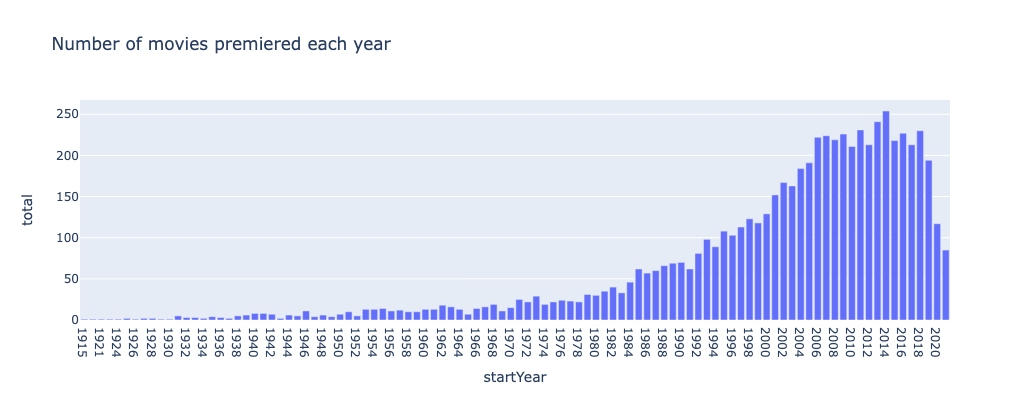

In [177]:
# Run this call to generate the bar plot; no further action is needed
px.bar(res_q1b, x="startYear", y="total", 
        title="Number of movies premiered each year", 
        width=900, height=400)

<br/><br/>

---

## Question 2

Who are the **top 10 most prolific movie actors**?

The term **"movie actor"** is defined as anyone with an `"actor"` or `"actress"` job category role in a `"movie"` title type.

Your SQL query should output exactly two fields named `name` (the movie actor's name) and `total` (the number of movies the movie actor appears in). Order the records by `total` in **descending** order, and break ties by ordering by `name` in **ascending** order.

Your result should look something like this (but without `????`):

| name | total |
|-----:|-----:|
| ???? | 64 |
| ???? | 54 |
| ???? | 53 |
| ???? | 49 |
| ???? | 46 |
| ???? | 43 |
| ???? | 41 |
| ???? | 40 |
| ???? | 40 |
| ???? | 39 |

**Notes**: 
* **The query should take < 2 minutes to run.**
* Sometimes Python gets confused and colors some SQL queries red; *don't worry if the SQL coloring doesn't match what you'd expect*. As long as it runs, it's fine.

**Hints**:

* Before writing your query, you may wish to review the table descriptions given at the start of the assignment to determine where the information you need is stored
* If you want to include a non-aggregate field in the `SELECT` clause, it must also be included in the `GROUP BY` clause.
* When using multiple conditions in a `WHERE` clause, pay attention to the order of operations.

In [178]:
%%sql --save query_q2

WITH actors_actresses AS ( 
    SELECT primaryName AS name, tconst
    FROM Name
    JOIN Role ON Name.nconst = Role.nconst
    WHERE category = 'actor' OR category = 'actress'
)
SELECT name, COUNT(*) AS total
FROM actors_actresses a
JOIN Title ON a.tconst = Title.tconst
WHERE titleType = 'movie'
GROUP BY name
ORDER BY total DESC, name
LIMIT 10;

Running query in 'duckdb:///data/imdbmini.db'

name,total
Robert De Niro,64
Samuel L. Jackson,54
Nicolas Cage,53
Bruce Willis,49
Tom Hanks,46
Johnny Depp,43
Mark Wahlberg,41
Liam Neeson,40
Morgan Freeman,40
Adam Sandler,39


In [179]:
# Run this cell for grading purposes. 
# No further action is required. 
query = %sqlcmd snippets query_q2
res_q2 = pd.read_sql(query, "duckdb:///data/imdbmini.db")

In [180]:
grader.check("q2")

q2 results: All test cases passed!

<br/><br/>

---

## Question 3: The `CASE` Keyword

The `rating` table has the `numVotes` and the `averageRating` for each title. A movie is considered a **"big hit**" if there are more than 100,000 votes for the movie. Which `movie` titles were **"big hits"**? Construct a query that generates the following result:

| isBigHit | total |
|-----:|-----|
| no | ???? |
| yes | ???? |

Where `????` is replaced with the correct values. The row with `no` should have the count for how many movies **are not** big hits, and the row with `yes` should have the count of how many movies **are** big hits.

**Hints**:

* Check the data types of `numVotes` and `averageRating` before performing any arithmetic operations.
* You will need to use some type of `JOIN`.
* You may also consider using a `CASE` statement:
    ```
    CASE 
        WHEN ... THEN ...
        ELSE ... 
    END
    ```
    </br>
    
  `CASE` statements are the SQL equivalent of `Python` `if... elif... else` statements. To read up on `CASE`, take a look at the following links:
    - https://mode.com/sql-tutorial/sql-case/
    - https://www.w3schools.com/sql/sql_ref_case.asp


In [181]:
%%sql --save query_q3

WITH bigHitDB AS (
    SELECT CAST(numVotes AS int) AS intNumVotes,
        CASE WHEN intNumVotes > 100_000 THEN 'yes'
        ELSE 'no'
        END AS isBigHit
    FROM Rating
    JOIN Title ON Rating.tconst = Title.tconst
    WHERE titleType = 'movie'
)
SELECT isBigHit, COUNT(*) AS total
FROM bigHitDB
GROUP BY isBigHit

Running query in 'duckdb:///data/imdbmini.db'

isBigHit,total
no,4318
yes,2041


In [182]:
%%sql
SELECT COUNT(*)
FROM Title
WHERE titleType = 'movie'

Running query in 'duckdb:///data/imdbmini.db'

count_star()
6359


In [183]:
4318 + 2041

6359

In [184]:
# Run this cell for grading purposes. 
# No further action is required. 
query = %sqlcmd snippets query_q3
res_q3 = pd.read_sql(query, "duckdb:///data/imdbmini.db")

In [185]:
grader.check("q3")

q3 results: All test cases passed!

<br/><br/>

---

## Question 4

**How does movie length relate to ratings?**  To answer this question we want to bin `movie` titles by length, compute the average of the average ratings within each length bin, and visualize the relations.

### Question 4a

We will group movies by 10-minute increments —— that is, one bin for movies \[0, 10) minutes long, another for \[10, 20) minutes, another for \[20, 30) minutes, and so on. Use the following code snippet to help construct 10-minute bins: 

```
ROUND(CAST(runtimeMinutes AS int)/ 10.0 + 0.5) * 10 AS runtimeBin
```

Construct a query that generates a resulting table containing the **`runtimeBin`**, the **average** of the **average ratings** (as `averageRating`), the **average number of votes** (as `averageNumVotes`), and the number of `titles` in that **runtimeBin** (as `total`).  Only include movies with **at least 25,000 votes**.  Order the final results by the value of `runtimeBin` in ascending order.

**Hints**: 
* Like in previous questions, we are only focusing on **movies**.
* Check the data types of `numVotes` and `averageRating` before performing any arithmetic operations.
* You can use a variable(s) defined in your `SELECT` clause in the later part of your query.

**Note**: DO NOT cast `averageRating` **as an integer**. Doing so reduces the precision of the resulting values.

In [186]:
%%sql

SELECT primaryTitle, numVotes
FROM Title
JOIN Rating ON Title.tconst = Rating.tconst
WHERE 
    CAST(numVotes AS int) >= 25_000 AND
    titleType = 'movie'
LIMIT 10;

Running query in 'duckdb:///data/imdbmini.db'

primaryTitle,numVotes
The Cabinet of Dr. Caligari,60244
The Kid,120059
Nosferatu,92218
Sherlock Jr.,45878
Battleship Potemkin,55425
Metropolis,166671
The General,86751
The Circus,32189
The Passion of Joan of Arc,51335
All Quiet on the Western Front,59313


In [187]:
%%sql --save query_q4a

SELECT 
    ROUND(CAST(runtimeMinutes AS int)/ 10.0 + 0.5) * 10 AS runtimeBin, 
    AVG(CAST(averageRating AS float)) AS averageRating,
    AVG(CAST(numVotes AS int)) AS averageNumVotes,
    COUNT(*) AS total
FROM Title
JOIN Rating ON Title.tconst = Rating.tconst
WHERE 
    CAST(numVotes AS int) >= 25_000 AND
    titleType = 'movie'
GROUP BY runtimeBin
ORDER BY runtimeBin ;

Running query in 'duckdb:///data/imdbmini.db'

runtimeBin,averageRating,averageNumVotes,total
50.0,7.849999904632568,42535.0,2
60.0,6.300000190734863,38226.0,1
70.0,7.725000083446503,82923.25,8
80.0,6.941509467250896,77314.45283018867,53
90.0,6.307692300257217,86678.89604989605,481
100.0,6.44035802409356,92955.17249796583,1229
110.0,6.600877194313341,112399.62918660288,1254
120.0,6.783097164350965,134306.2064777328,988
130.0,7.050076116891393,165226.49162861492,657
140.0,7.200990113586482,198210.75247524751,404


In [188]:
# Run this cell for grading purposes. 
# No further action is required. 
query = %sqlcmd snippets query_q4a
res_q4a = pd.read_sql(query, "duckdb:///data/imdbmini.db")

In [189]:
grader.check("q4a")

q4a results: All test cases passed!

<br><br>

Let us take a look at the current distribution of movie runtimes.

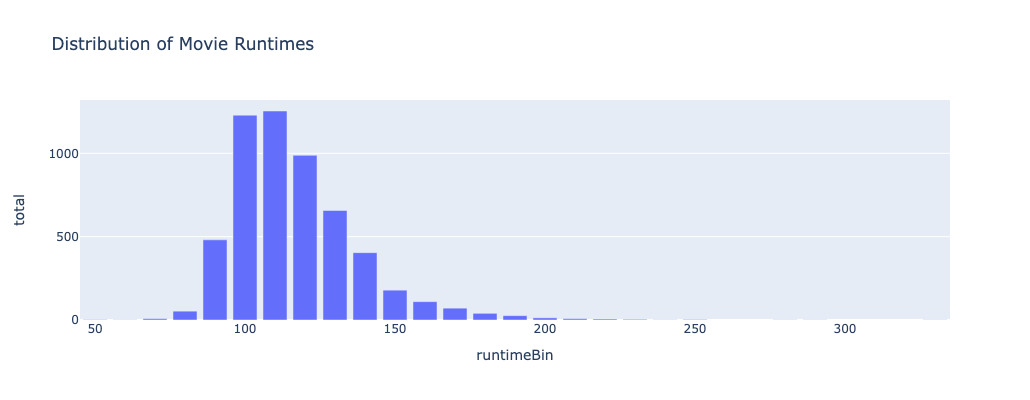

In [190]:
# Run the cell below; no further action is needed
px.bar(res_q4a, x="runtimeBin", y="total", 
       title="Distribution of Movie Runtimes", width = 800, height = 400)

In [191]:
res_q4a.head()

,runtimeBin,averageRating,averageNumVotes,total
0,50.0,7.850000,42535.00000,2
1,60.0,6.300000,38226.00000,1
2,70.0,7.725000,82923.25000,8
3,80.0,6.941509,77314.45283,53
4,90.0,6.307692,86678.89605,481


<!-- BEGIN QUESTION -->

<br><br>

---

### Question 4b

Create two line plots below. The first should show the relationship between average number of votes and runtime; the second should show the relationship between average rating and runtime. The runtime should be on the x-axis for both plots. Use the columns from the table generated in the previous part, `res_q4a`. If your SQL query is correct, you should get some interesting plots below. This might explain why directors keep going with a particular range of runtimes. 

**Notes**:
* Please use `sns` or `plt` functions for plotting. Plotly `px` does not export to the PDF properly.
* Please include descriptive titles and labels.
* If your plot does not show up in the generated PDF, please upload a PDF with a screenshot of your code and the plot.

Text(0, 0.5, 'Average # of Votes')

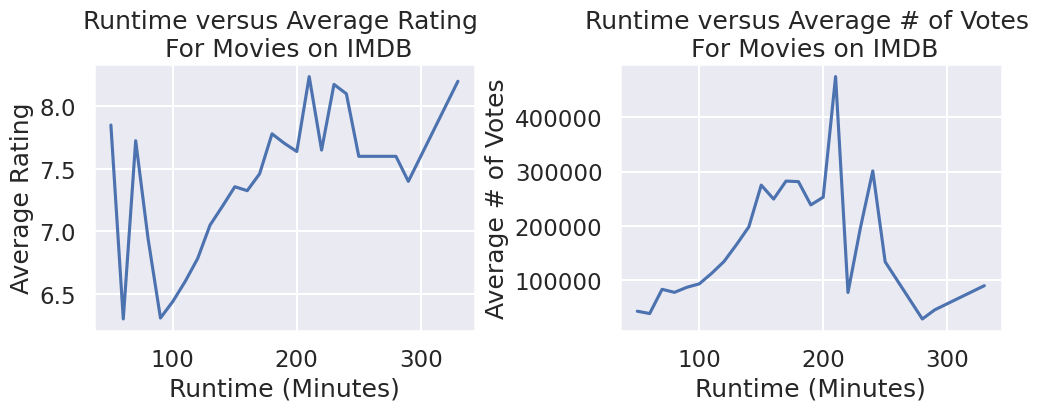

In [192]:
plt.figure(figsize=(10, 4), layout='constrained')
plt.subplot(1, 2, 1) # DO NOT MODIFY THIS LINE
plt.plot('runtimeBin', 'averageRating', data=res_q4a)
plt.title('Runtime versus Average Rating \n For Movies on IMDB')
plt.xlabel('Runtime (Minutes)')
plt.ylabel('Average Rating')
plt.subplot(1, 2, 2) # DO NOT MODIFY THIS LINE
plt.plot('runtimeBin', 'averageNumVotes', data=res_q4a)
plt.title('Runtime versus Average # of Votes \n For Movies on IMDB')
plt.xlabel('Runtime (Minutes)')
plt.ylabel('Average # of Votes')

<!-- END QUESTION -->

<br/><br/>

---

## Question 5


Which **movie actors** have the highest average ratings across all the movies in which they star? Again, define **"movie actor"** as anyone with an `actor` or `actress` job category role in a `movie` title type.

Construct a query that generates a resulting table consisting of the **movie actor's name**  (as `name`) and their **average actor rating** (as `actorRating`) computed by rescaling ratings for movies in which they had a role:

$$
\text{actorRating} = 
\frac{\sum_m (\text{averageRating}[m] * \text{numVotes}[m] )}{\sum_m \text{numVotes}[m]}
$$

In addition, only consider ratings where there are **at least 22,000** votes and only consider movie actors that have **at least 20 rated performances**. Present the movie actors with the **top 10** `actorRating` in **descending** order and break ties alphabetically using the movie actor's name.

The results should look something like this but without the `????`, and with higher rating precision.

| name | actorRating |
|-----:|:-----|
|????|8.4597...|
|????|8.1432...|
|????|8.1403...|
|????|8.0349...|
|????|7.9898...|
|????|7.9348...|
|????|7.9330...|
|????|7.8668...|
|????|7.8567...|
|????|7.8479...|

**Hint**: Check the data types of `numVotes` and `averageRating` before performing any arithmetic operations.

**Notes**:
* ***The query should take < 3 minutes to run.***
* DO NOT cast `averageRating` **as an integer**. Doing so reduces the precision of the resulting values, so your table may not match up exactly with what is shown below.
* If an actor/actress has multiple `role` listings for a movie, then that movie will have a bigger impact on the overall average (this is desired).

In [220]:
%%sql

WITH actors_actresses AS ( 
    SELECT primaryName AS name, tconst
    FROM Name
    JOIN Role ON Name.nconst = Role.nconst
    WHERE category = 'actor' OR category = 'actress'
),
movies_20k AS (
    SELECT 
        CAST(numVotes AS int) AS intNumVotes,
        CAST(averageRating AS float) AS floatAverageRating,
        CAST(numVotes AS float) * floatAverageRating AS ratingScore,
        Title.tconst
    FROM Rating
    JOIN Title ON Rating.tconst = Title.tconst
    WHERE titleType = 'movie' AND intNumVotes >= 22_000
), 
actors_counts AS (
    SELECT name, COUNT(*) AS total
    FROM actors_actresses AS a
    JOIN movies_20k AS m
    ON a.tconst = m.tconst
    GROUP BY name
    ORDER BY total DESC
),
actors_20 AS (
    SELECT 
        a.name,
        tconst
    FROM actors_actresses AS a
    JOIN actors_counts AS b
    ON a.name = b.name
    WHERE total >= 20
)
SELECT name, SUM(ratingScore) / SUM(intNumVotes) AS actorRating
FROM actors_20 a
JOIN movies_20k b
ON a.tconst = b.tconst
GROUP BY name
ORDER BY actorRating DESC, name
LIMIT 10;

Running query in 'duckdb:///data/imdbmini.db'

name,actorRating
Diane Keaton,8.459749306914137
Al Pacino,8.143296547996608
Michael Caine,8.140341554923678
Leonardo DiCaprio,8.03496089527195
Christian Bale,7.989825259062718
Kevin Spacey,7.9348882127969205
Jack Nicholson,7.933033463121602
Clint Eastwood,7.866838620708466
Edward Norton,7.856717980284558
Tom Hanks,7.847982328558773


In [221]:
%%sql --save query_q5

WITH actors_actresses AS ( 
    SELECT primaryName AS name, tconst
    FROM Name
    JOIN Role ON Name.nconst = Role.nconst
    WHERE category = 'actor' OR category = 'actress'
),
movies_20k AS (
    SELECT 
        CAST(numVotes AS int) AS intNumVotes,
        CAST(averageRating AS float) AS floatAverageRating,
        CAST(numVotes AS float) * floatAverageRating AS ratingScore,
        Title.tconst
    FROM Rating
    JOIN Title ON Rating.tconst = Title.tconst
    WHERE titleType = 'movie' AND intNumVotes >= 22_000
), 
actors_counts AS (
    SELECT name, COUNT(*) AS total
    FROM actors_actresses AS a
    JOIN movies_20k AS m
    ON a.tconst = m.tconst
    GROUP BY name
    ORDER BY total DESC
),
actors_20 AS (
    SELECT 
        a.name,
        tconst
    FROM actors_actresses AS a
    JOIN actors_counts AS b
    ON a.name = b.name
    WHERE total >= 20
)
SELECT name, SUM(ratingScore) / SUM(intNumVotes) AS actorRating
FROM actors_20 a
JOIN movies_20k b
ON a.tconst = b.tconst
GROUP BY name
ORDER BY actorRating DESC, name
LIMIT 10;


Running query in 'duckdb:///data/imdbmini.db'

name,actorRating
Diane Keaton,8.459749306914137
Al Pacino,8.143296547996608
Michael Caine,8.140341554923678
Leonardo DiCaprio,8.03496089527195
Christian Bale,7.989825259062718
Kevin Spacey,7.9348882127969205
Jack Nicholson,7.933033463121602
Clint Eastwood,7.866838620708466
Edward Norton,7.856717980284558
Tom Hanks,7.847982328558773


In [225]:
# Run this cell for grading purposes. 
# No further action is required. 
query = %sqlcmd snippets query_q5
res_q5 = pd.read_sql(query, "duckdb:///data/imdbmini.db")

In [226]:
grader.check("q5")

q5 results: All test cases passed!


<br><br>


<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Yogi and Miya congratulate you for finishing Homework 7!

<img src="images/yogi.jpg" width="300"/> <img src="images/miya.png" width="300"/>

### Course Content Feedback

If you have any feedback about this assignment or about any of our other weekly, weekly assignments, lectures, or discussions, please fill out the [Course Content Feedback Form](https://docs.google.com/forms/d/e/1FAIpQLSe0fBEJwt6aEfZxU3fh3llNk8rSWHj6Umq0km3wPqmFu0MlGA/viewform). Your input is valuable in helping us improve the quality and relevance of our content to better meet your needs and expectations!

### Submission Instructions

Below, you will see a cell. Running this cell will automatically generate a zip file with your autograded answers. Once you submit this file to the Homework 7 Coding assignment on Gradescope, Gradescope will automatically submit a PDF file with your written answers to the Homework 7 Written assignment. If you run into any issues when running this cell, feel free to check the ["Why did a Gradescope test fail when all the Jupyter notebook’s tests passed?"](https://ds100.org/debugging-guide/autograder_gradescope/autograder_gradescope.html#why-did-a-gradescope-test-fail-when-all-the-jupyter-notebooks-tests-passed) section of the Data 100 Debugging Guide.

If there are issues with automatically generating the PDF, try downloading the notebook as a PDF by clicking on `File -> Save and Export Notebook As... -> PDF`. If that doesn't work, download the notebook as an HTML file by clicking on `File -> Save and Export Notebook As... -> HTML`, open the HTML file in your browser, and Ctrl + P or Cmd + P (Mac) to save the file as a PDF. Alternatively, you can  manually take screenshots of your answers to the manually graded questions and submit a PDF containing those. 

**You are responsible for ensuring your submission follows our requirements and that everything was generated and submitted correctly. We will not be granting regrade requests nor extensions to submissions that don't follow instructions.** If you encounter any difficulties with submission, please don't hesitate to reach out to staff prior to the deadline. 

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)

Running your submission against local test cases...

